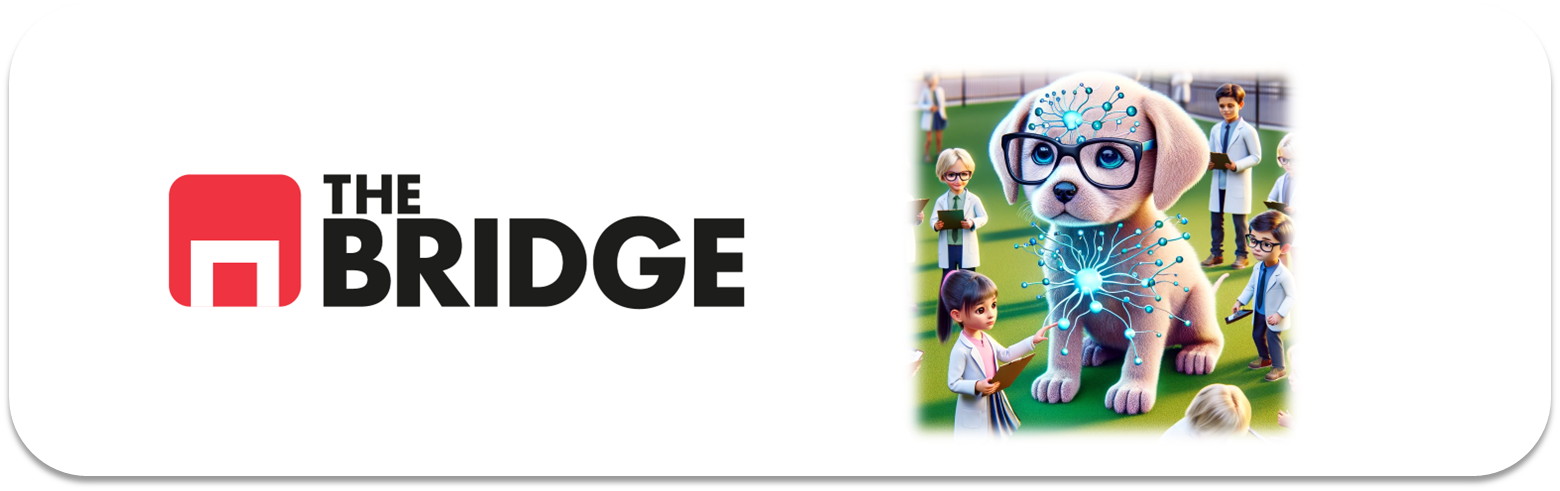

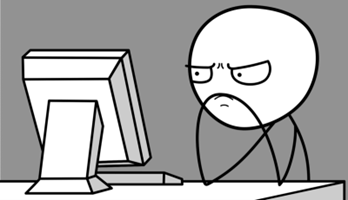

Para ejercitarte y afianzar lo aprendido sobre **Redes Recurrentes y series temporales**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [3]:
import numpy as np
import pandas as pd
import sys
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

from pmdarima.arima import ARIMA, auto_arima
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from packaging import version
assert version.parse(tf.__version__) >= version.parse("2.8.0")

import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

### Problema a resolver

El ayuntamiento de New City está preocupado por el nivel de contaminación de aire y quiere poner en marcha un sistema de prevención del uso de determinado tipo de vehículos y maquinaria pesada en aquellos días en los que la contaminación sea muy alta, en concreto queremos anticiparnos en periodos de 6 horas. Como primer paso para la implantación de la medida, decide crear un modelo de predicción de contaminación de forma que pueda emplearlo para enviar alertas o avisos de posible de prohibición con la suficiente anticipación que permita a los ciudadanos y trabajadores organizarse mejor. 

Para ello nos ha suministrado una serie de datos de contaminación del aire en cinco años dependiente de una serie de features que son medibles día a día y nos pide crear dicho modelo. Como somos unos "pioneros" vamos a hacerlo empleando lo aprendido con redes recurrentes.

A través de los siguientes ejercicios vamos a crear un modelo de regresión que permita estimar dicha polución en los periodos estimados. Aquí tienes un breve descripción de las columnas:

- **No**: número de fila
- **year**: año de los datos en esta fila
- **month**: mes de los datos en esta fila
- **day**: día de los datos en esta fila
- **hour**: hora de los datos en esta fila
- **pm2.5**: concentración de PM2.5
- **DEWP**: Punto de rocío
- **TEMP**: Temperatura
- **PRES**: Presión
- **cbwd**: Dirección combinada del viento
- **Iws**: Velocidad acumulada del viento
- **Is**: Horas acumuladas de nieve
- **Ir**: Horas acumuladas de lluvia


### Ejercicio 1: Visión preliminar

Carga el dataset. Echa un vistazo (no pintes series todavía) y decide cuál debe ser el target.

In [4]:
df = pd.read_csv("./data/air_pollution_new_city.csv", sep="|")
df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,25,2019,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,26,2019,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,27,2019,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,28,2019,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,29,2019,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,43820,2023,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43796,43821,2023,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43797,43822,2023,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43798,43823,2023,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [5]:
target = "pm2.5"

### Ejercicio 2: Preparación del dataset

Como todo dataset con series temporales, si tenemos las fechas, es conveniente convertirla a datatime y luego hacerlo el indice de nuestro dataset. Hazlo sobre un dataframe df_indexed copia del original. Deshazte de las columnas que no sean informativas y cambia el nombre de las columnas para que sean más "expresivas".

In [6]:
df_indexed = df.copy()

In [7]:
df_indexed["date"] = pd.to_datetime(df_indexed[["year","month", "day", "hour"]])
df_indexed.set_index("date", inplace= True)

In [8]:
# Eliminar las columnas year, month, day y hour
df_indexed.drop(columns=["year", "month", "day", "hour"], inplace=True)

In [9]:
df_indexed.rename(columns={"pm2.5": "contaminacion","cbwd":"direccion_viento", "DEWP": "punto_rocio", "TEMP": "temperatura", "PRES": "presion", "Iws": "vel_viento", "Is": "nieve", "Ir": "lluvia"}, inplace=True)
df_indexed.drop(["No"], axis=1, inplace=True)
df_indexed

,contaminacion,punto_rocio,temperatura,presion,direccion_viento,vel_viento,nieve,lluvia
date,,,,,,,,
2019-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2019-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2019-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2019-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2019-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2023-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2023-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [10]:
df_indexed.describe()

,contaminacion,punto_rocio,temperatura,presion,vel_viento,nieve,lluvia
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


### Ejercicio 3: Split y MiniEda_I

Antes de continuar es hora analizar visualmente las series, pero para hacerlo formalmente correcto, analiza sólo de 2019 a 2022 (2023 será nuestro periodo de validaciones y test). Crea una gráfica com el target para el periodo de train. Descompón la serie de forma aditiva y analiza visualmente si existe estacionalidad, tendencia y si podríamos decir si es estacionaria o no

In [11]:
inicio = "2019-01-02-00"
final_train = "2022-12-31-23"
final = "2023-12-31-23"

# Sort the index
df_indexed.sort_index(inplace=True)

train = df_indexed[inicio:final_train]
train

,contaminacion,punto_rocio,temperatura,presion,direccion_viento,vel_viento,nieve,lluvia
date,,,,,,,,
2019-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2019-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2019-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2019-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2019-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,22.0,-19,7.0,1013.0,NW,114.87,0,0
2022-12-31 20:00:00,18.0,-21,7.0,1014.0,NW,119.79,0,0
2022-12-31 21:00:00,23.0,-21,7.0,1014.0,NW,125.60,0,0


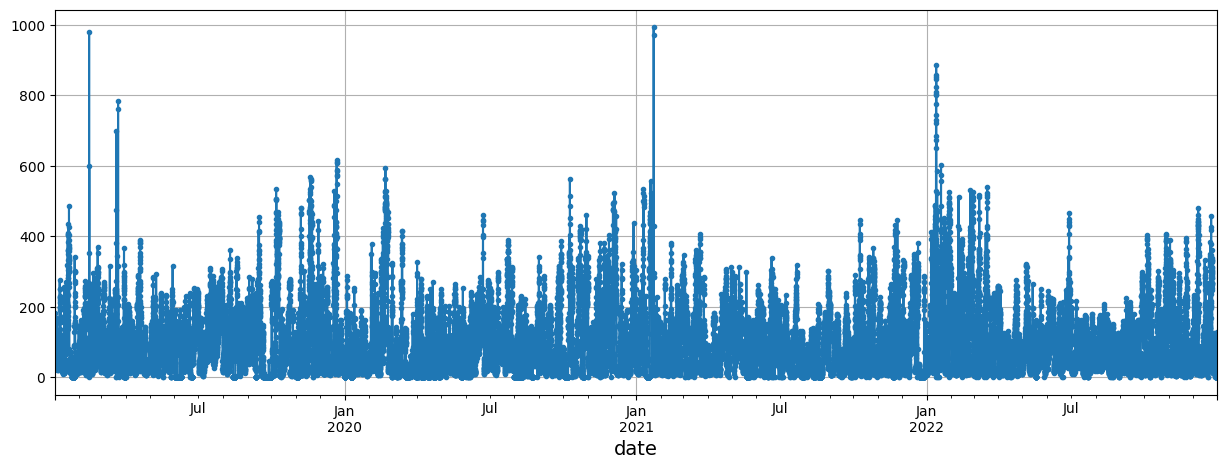

In [12]:
train["contaminacion"].plot(grid=True, marker =".", figsize=(15,5));

<Axes: xlabel='date'>

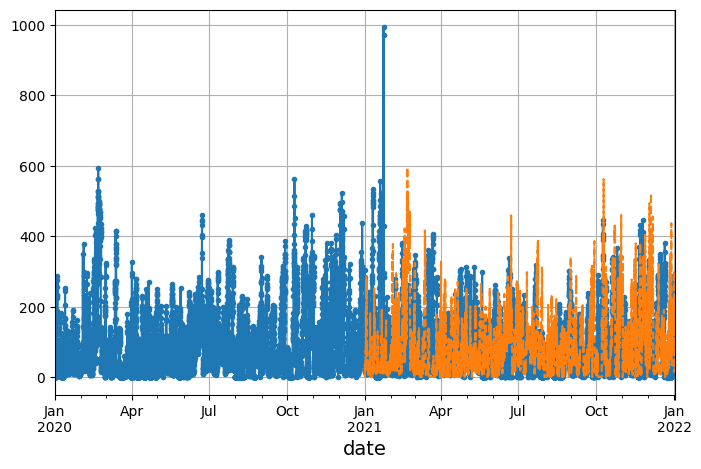

In [13]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5))
train["contaminacion"]["2020-01-01-00":"2022-01-01-23"].plot(ax=axs, legend=False, marker=".")  # original time series
train["contaminacion"]["2020-01-01-00":"2022-01-01-23"].shift(24*365).plot(ax=axs, grid=True, legend=False, linestyle="--")  # lagged

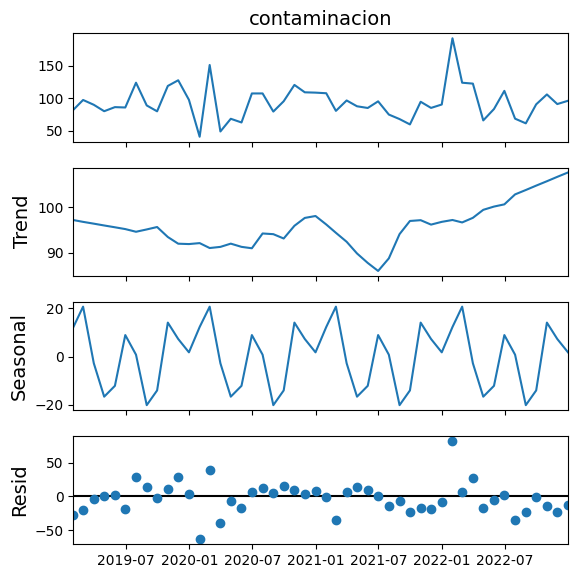

In [14]:
df_mensualizada = train["contaminacion"].resample("M").mean(numeric_only= True)
result_add = seasonal_decompose(df_mensualizada, model = 'additive', 
                                extrapolate_trend = 'freq')

# Plot
plt.rcParams.update({'figure.figsize': (6,6)})
result_add.plot();

In [15]:
df_mensualizada.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 48 entries, 2019-01-31 to 2022-12-31
Freq: ME
Series name: contaminacion
Non-Null Count  Dtype  
--------------  -----  
48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


In [16]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train["contaminacion"].values)
result[1]

0.0

In [397]:
# El p-value es menor de 0.05 así que podemos rechazar la hipótesis nula de no estacionariedad

### Ejercicio 4: MiniEDA (II)

Para completar el minieda, crea una figura con tantos subplots como series temporales y en cada subplot muestra una de las series para el train. Empieza por el target y haz un pequeño análisis visual. Por supuesto, emplea sólo el train

In [17]:
train.columns.to_list()

['contaminacion',
 'punto_rocio',
 'temperatura',
 'presion',
 'direccion_viento',
 'vel_viento',
 'nieve',
 'lluvia']

In [399]:
# import matplotlib.pyplot as plt
# import pandas as pd



# # Listar las columnas de las variables que quieres analizar
# variables = [ 'contaminacion',
#  'punto_rocio',
#  'temperatura',
#  'presion',
#  'direccion_viento',
#  'vel_viento',
#  'nieve',
#  'lluvia'] 



# # Crear gráficos por cada componente temporal
# fig, axes = plt.subplots(nrows=len(variables) + 1, ncols=4, figsize=(20, 5 * (len(variables) + 1)))

# for i, var in enumerate(variables):
#     # Gráfico por año
#     train.groupby('year')[var].mean().plot(ax=axes[i, 0])
#     axes[i, 0].set_title(f'{var} por Año')

#     # Gráfico por mes
#     train.groupby('month')[var].mean().plot(ax=axes[i, 1])
#     axes[i, 1].set_title(f'{var} por Mes')

#     # Gráfico por día
#     train.groupby('day')[var].mean().plot(ax=axes[i, 2])
#     axes[i, 2].set_title(f'{var} por Día')

#     # Gráfico por hora
#     train.groupby('hour')[var].mean().plot(ax=axes[i, 3])
#     axes[i, 3].set_title(f'{var} por Hora')

# # Handle 'direccion-viento' separately
# i = len(variables)
# train['direccion_viento'].value_counts().plot(kind='bar', ax=axes[i, 0])
# axes[i, 0].set_title('direccion-viento por Año')
# axes[i, 1].axis('off')
# axes[i, 2].axis('off')
# axes[i, 3].axis('off')

# plt.tight_layout()
# plt.show()



### Ejercicio 5

Vamos a preparar el dataset. En principio vamos a predecir el valor de las siguientes 12 horas a partir de las 48 horas anteriores. Es decir hay que ajustar el dataset para que genere batches de 32 secuencias de 48 instancias y con un target que es una secuencia de los 12 periodos siguientes. Primero codifica la dirección del viento con un one-hot encoding sobre el df_indexed. Convierte todos los valores a np.float32 al final: 

In [18]:
df_indexed_2 = pd.get_dummies(df_indexed, columns=['direccion_viento'])
df_indexed_2

,contaminacion,punto_rocio,temperatura,presion,vel_viento,nieve,lluvia,direccion_viento_NE,direccion_viento_NW,direccion_viento_SE,direccion_viento_cv
date,,,,,,,,,,,
2019-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,False,False,True,False
2019-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,False,False,True,False
2019-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,False,False,True,False
2019-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,False,False,True,False
2019-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,8.0,-23,-2.0,1034.0,231.97,0,0,False,True,False,False
2023-12-31 20:00:00,10.0,-22,-3.0,1034.0,237.78,0,0,False,True,False,False
2023-12-31 21:00:00,10.0,-22,-3.0,1034.0,242.70,0,0,False,True,False,False


In [19]:
df_indexed_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43800 entries, 2019-01-02 00:00:00 to 2023-12-31 23:00:00
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   contaminacion        43800 non-null  float64
 1   punto_rocio          43800 non-null  int64  
 2   temperatura          43800 non-null  float64
 3   presion              43800 non-null  float64
 4   vel_viento           43800 non-null  float64
 5   nieve                43800 non-null  int64  
 6   lluvia               43800 non-null  int64  
 7   direccion_viento_NE  43800 non-null  bool   
 8   direccion_viento_NW  43800 non-null  bool   
 9   direccion_viento_SE  43800 non-null  bool   
 10  direccion_viento_cv  43800 non-null  bool   
dtypes: bool(4), float64(4), int64(3)
memory usage: 3.8 MB


In [20]:
df_indexed_2 = df_indexed_2.astype(np.float32)
df_indexed_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43800 entries, 2019-01-02 00:00:00 to 2023-12-31 23:00:00
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   contaminacion        43800 non-null  float32
 1   punto_rocio          43800 non-null  float32
 2   temperatura          43800 non-null  float32
 3   presion              43800 non-null  float32
 4   vel_viento           43800 non-null  float32
 5   nieve                43800 non-null  float32
 6   lluvia               43800 non-null  float32
 7   direccion_viento_NE  43800 non-null  float32
 8   direccion_viento_NW  43800 non-null  float32
 9   direccion_viento_SE  43800 non-null  float32
 10  direccion_viento_cv  43800 non-null  float32
dtypes: float32(11)
memory usage: 3.2 MB


In [21]:
df_indexed_2

,contaminacion,punto_rocio,temperatura,presion,vel_viento,nieve,lluvia,direccion_viento_NE,direccion_viento_NW,direccion_viento_SE,direccion_viento_cv
date,,,,,,,,,,,
2019-01-02 00:00:00,129.0,-16.0,-4.0,1020.0,1.790000,0.0,0.0,0.0,0.0,1.0,0.0
2019-01-02 01:00:00,148.0,-15.0,-4.0,1020.0,2.680000,0.0,0.0,0.0,0.0,1.0,0.0
2019-01-02 02:00:00,159.0,-11.0,-5.0,1021.0,3.570000,0.0,0.0,0.0,0.0,1.0,0.0
2019-01-02 03:00:00,181.0,-7.0,-5.0,1022.0,5.360000,1.0,0.0,0.0,0.0,1.0,0.0
2019-01-02 04:00:00,138.0,-7.0,-5.0,1022.0,6.250000,2.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,8.0,-23.0,-2.0,1034.0,231.970001,0.0,0.0,0.0,1.0,0.0,0.0
2023-12-31 20:00:00,10.0,-22.0,-3.0,1034.0,237.779999,0.0,0.0,0.0,1.0,0.0,0.0
2023-12-31 21:00:00,10.0,-22.0,-3.0,1034.0,242.699997,0.0,0.0,0.0,1.0,0.0,0.0


### Ejercicio 6

Ahora crea los datasets de train, validación y test. El primero para que tenga el periodo 2020 septiembre de 2023, el segundo para octubre de 2023 y el tercero para noviembre de 2023. Ojo ten en cuenta que vamos a necesitar tanto los valores anteriores como posteriores en los periodos (48 horas antes y 12 horas después). Escálalos (importante, escala el target por separado para poder hacer la inversión en el momento de evaluar)

In [22]:
# inicio = "2019-01-02-00"
# final_train = "2022-12-31-23"
# final = "2023-12-31-23"
inicio_train = "2019-12-30-00"
final_train = "2023-10-01-12"
inicio_val = "2023-09-29-00"
final_val = "2023-11-01-12"
inicio_test = "2023-10-30-00"
final_test = "2023-12-01-12"

train = df_indexed_2[inicio_train:final_train]
val = df_indexed_2[inicio_val:final_val]
test = df_indexed_2[inicio_test:final_test]

In [23]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Debido a que el target tiene outliers, vamos a aplicarle log+1
train["contaminacion"] = np.log1p(train["contaminacion"])
val["contaminacion"] = np.log1p(val["contaminacion"])   
test["contaminacion"] = np.log1p(test["contaminacion"])

# Crear el scaler para la normalización del target 
scaler_target = MinMaxScaler()

# Aplicar la normalización sólo a la variable seleccionada
train["contaminacion"] = scaler_target.fit_transform(train[["contaminacion"]])
val["contaminacion"] = scaler_target.transform(val[["contaminacion"]])
test["contaminacion"] = scaler_target.transform(test[["contaminacion"]])

# Para desnormalizar el target al evaluar
# target_pred = scaler_target.inverse_transform(target_pred_scaled)  # Desnormalización
train.head()

,contaminacion,punto_rocio,temperatura,presion,vel_viento,nieve,lluvia,direccion_viento_NE,direccion_viento_NW,direccion_viento_SE,direccion_viento_cv
date,,,,,,,,,,,
2019-12-30 00:00:00,0.418728,-21.0,-7.0,1027.0,133.210007,0.0,0.0,0.0,1.0,0.0,0.0
2019-12-30 01:00:00,0.418728,-21.0,-8.0,1027.0,138.130005,0.0,0.0,0.0,1.0,0.0,0.0
2019-12-30 02:00:00,0.418728,-21.0,-8.0,1026.0,145.279999,0.0,0.0,0.0,1.0,0.0,0.0
2019-12-30 03:00:00,0.392315,-22.0,-8.0,1026.0,151.089996,0.0,0.0,0.0,1.0,0.0,0.0
2019-12-30 04:00:00,0.392315,-22.0,-8.0,1026.0,158.240005,0.0,0.0,0.0,1.0,0.0,0.0


In [26]:
scaler_resto = StandardScaler()

# Aplicar la normalización a las variables restantes
train.iloc[:, 1:] = scaler_resto.fit_transform(train.iloc[:, 1:])
val.iloc[:, 1:] = scaler_resto.transform(val.iloc[:, 1:])
test.iloc[:, 1:] = scaler_resto.transform(test.iloc[:, 1:])   

train.head()

,contaminacion,punto_rocio,temperatura,presion,vel_viento,nieve,lluvia,direccion_viento_NE,direccion_viento_NW,direccion_viento_SE,direccion_viento_cv
date,,,,,,,,,,,
2019-12-30 00:00:00,0.418728,-1.599963,-1.645051,1.050247,2.276959,-0.07145,-0.138325,-0.360506,1.495127,-0.750241,-0.524511
2019-12-30 01:00:00,0.418728,-1.599963,-1.726981,1.050247,2.378271,-0.07145,-0.138325,-0.360506,1.495127,-0.750241,-0.524511
2019-12-30 02:00:00,0.418728,-1.599963,-1.726981,0.954751,2.525501,-0.07145,-0.138325,-0.360506,1.495127,-0.750241,-0.524511
2019-12-30 03:00:00,0.392315,-1.668637,-1.726981,0.954751,2.645140,-0.07145,-0.138325,-0.360506,1.495127,-0.750241,-0.524511
2019-12-30 04:00:00,0.392315,-1.668637,-1.726981,0.954751,2.792371,-0.07145,-0.138325,-0.360506,1.495127,-0.750241,-0.524511


In [27]:
train.shape

(32917, 11)

In [28]:
val.shape

(805, 11)

In [29]:
test.shape

(781, 11)

In [30]:
# Creamos batches de 32 secuencias formadas por 48 horas y el target el las 12 horas siguientes
seq_length = (48)
tf.random.set_seed(42)

def split_inputs_and_targets(data, ahead= 12, target_col= 5):
    return data[:,:-ahead], data[:,-ahead:,target_col]

train_ds = tf.keras.utils.timeseries_dataset_from_array(
    train.to_numpy(),
    targets = None,
    sequence_length=seq_length+12,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)

In [31]:
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    val.to_numpy(),
    targets = None,
    sequence_length=seq_length+12,
    batch_size=32).map(split_inputs_and_targets)

In [32]:
list(train_ds)[1]

(<tf.Tensor: shape=(32, 48, 11), dtype=float32, numpy=
 array([[[ 0.53074   , -1.1192441 , -1.2354006 , ..., -0.66883963,
          -0.75024134,  1.9065392 ],
         [ 0.47200027, -1.2565924 , -1.3173306 , ...,  1.4951267 ,
          -0.75024134, -0.5245106 ],
         [ 0.44779918, -1.2565924 , -1.3992608 , ...,  1.4951267 ,
          -0.75024134, -0.5245106 ],
         ...,
         [ 0.47746775, -1.3939407 , -0.74381995, ..., -0.66883963,
          -0.75024134,  1.9065392 ],
         [ 0.48781997, -1.05057   , -1.2354006 , ..., -0.66883963,
          -0.75024134, -0.5245106 ],
         [ 0.48781997, -1.1192441 , -1.3173306 , ...,  1.4951267 ,
          -0.75024134, -0.5245106 ]],
 
        [[ 0.6047433 ,  0.3915867 ,  0.48513168, ..., -0.66883963,
           1.3329045 , -0.5245106 ],
         [ 0.6024972 ,  0.32291257,  0.48513168, ..., -0.66883963,
           1.3329045 , -0.5245106 ],
         [ 0.6024972 ,  0.32291257,  0.5670618 , ..., -0.66883963,
          -0.75024134, -0.524

In [33]:
list(valid_ds)[1]

(<tf.Tensor: shape=(32, 48, 11), dtype=float32, numpy=
 array([[[ 0.42656073, -0.15921128, -1.0854938 , ..., -2.1161861 ,
          -2.3131034 ,  4.110381  ],
         [ 0.4016648 , -0.15921128, -1.0787812 , ..., -2.1161861 ,
          -2.3131034 ,  4.110381  ],
         [ 0.41872802, -0.1639274 , -1.0787812 , ..., -2.1161861 ,
          -2.3131034 ,  4.110381  ],
         ...,
         [ 0.62352973,  0.52893496, -0.25223932, ...,  1.4951267 ,
          -0.75024134, -0.5245106 ],
         [ 0.6366237 ,  0.46026084, -0.3341694 , ...,  1.4951267 ,
          -0.75024134, -0.5245106 ],
         [ 0.62547433,  0.46026084, -0.25223932, ...,  1.4951267 ,
          -0.75024134, -0.5245106 ]],
 
        [[ 0.4016648 , -0.15921128, -1.0787812 , ..., -2.1161861 ,
          -2.3131034 ,  4.110381  ],
         [ 0.41872802, -0.1639274 , -1.0787812 , ..., -2.1161861 ,
          -2.3131034 ,  4.110381  ],
         [ 0.46040452, -0.1639274 , -1.0720687 , ..., -2.1161861 ,
           2.026393  , -1.799

### Ejercicio 8

Crea un modelo con una capa de celdas sencillas recurrentes con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.

In [34]:
ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 11]),
    tf.keras.layers.Dense(12)
])

In [35]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500, patience = None):
    patience = int(epochs//10) if patience == None else patience # Si no nos dan "paciencia" 
    # el 10% de las épocas
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience= patience, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae

In [36]:
fit_and_evaluate(ahead_model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1010 - mae: 0.2251 - val_loss: 0.0045 - val_mae: 0.0615
Epoch 2/500
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0721 - mae: 0.1197 - val_loss: 0.0025 - val_mae: 0.0455
Epoch 3/500
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0705 - mae: 0.1083 - val_loss: 0.0018 - val_mae: 0.0389
Epoch 4/500
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0697 - mae: 0.1027 - val_loss: 0.0015 - val_mae: 0.0346
Epoch 5/500
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0685 - mae: 0.0985 - val_loss: 0.0012 - val_mae: 0.0311
Epoch 6/500
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0672 - mae: 0.0951 - val_loss: 0.0010 - val_mae: 0.0290
Epoch 7/500
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0666 - mae: 0.0932 - val_loss: 8.9221e-04 - val_mae: 0.0272
Epoch 8/500
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0657 - mae: 0.0912 - val_loss: 7.9291e-04 - val_mae: 0.0256
Epoch 9/500
1027/1027 ━━━━━━━━━━━━━━

0.013559008948504925

In [37]:
val.head()

,contaminacion,punto_rocio,temperatura,presion,vel_viento,nieve,lluvia,direccion_viento_NE,direccion_viento_NW,direccion_viento_SE,direccion_viento_cv
date,,,,,,,,,,,
2023-09-29 00:00:00,0.627393,-0.097902,-1.058644,-97.042236,-0.474908,-0.171121,-0.242239,8.333894,-2.116186,-2.313103,-1.799622
2023-09-29 01:00:00,0.634824,-0.097902,-1.058644,-97.042236,-0.474530,-0.171121,-0.242239,8.333894,-2.116186,-2.313103,-1.799622
2023-09-29 02:00:00,0.664224,-0.097902,-1.058644,-97.042236,-0.475289,-0.171121,-0.242239,-1.490471,-2.116186,-2.313103,4.110381
2023-09-29 03:00:00,0.675592,-0.107334,-1.065356,-97.051353,-0.474912,-0.171121,-0.242239,-1.490471,-2.116186,-2.313103,4.110381
2023-09-29 04:00:00,0.675592,-0.102618,-1.065356,-97.051353,-0.474534,-0.171121,-0.242239,-1.490471,-2.116186,-2.313103,4.110381


In [38]:
X = val.to_numpy()[np.newaxis, :seq_length]

In [39]:
Y_pred = ahead_model.predict(X)
Y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


array([[-0.2133314 , -0.1910317 , -0.21153075, -0.15152733, -0.15394555,
        -0.14797847, -0.14333151, -0.15292127, -0.15945838, -0.1830824 ,
        -0.18372688, -0.1632624 ]], dtype=float32)

In [40]:
Y_pred[0]

array([-0.2133314 , -0.1910317 , -0.21153075, -0.15152733, -0.15394555,
       -0.14797847, -0.14333151, -0.15292127, -0.15945838, -0.1830824 ,
       -0.18372688, -0.1632624 ], dtype=float32)

In [41]:
# inicio_val = "2023-09-29-00"
# final_val = "2023-11-01-12"
Y_pred = pd.Series(Y_pred[0],
                   index=pd.date_range("2023-11-01-01", periods=12))

In [42]:
Y_pred

2023-11-01 01:00:00   -0.213331
2023-11-02 01:00:00   -0.191032
2023-11-03 01:00:00   -0.211531
2023-11-04 01:00:00   -0.151527
2023-11-05 01:00:00   -0.153946
2023-11-06 01:00:00   -0.147978
2023-11-07 01:00:00   -0.143332
2023-11-08 01:00:00   -0.152921
2023-11-09 01:00:00   -0.159458
2023-11-10 01:00:00   -0.183082
2023-11-11 01:00:00   -0.183727
2023-11-12 01:00:00   -0.163262
Freq: D, dtype: float32

In [43]:
val

,contaminacion,punto_rocio,temperatura,presion,vel_viento,nieve,lluvia,direccion_viento_NE,direccion_viento_NW,direccion_viento_SE,direccion_viento_cv
date,,,,,,,,,,,
2023-09-29 00:00:00,0.627393,-0.097902,-1.058644,-97.042236,-0.474908,-0.171121,-0.242239,8.333894,-2.116186,-2.313103,-1.799622
2023-09-29 01:00:00,0.634824,-0.097902,-1.058644,-97.042236,-0.474530,-0.171121,-0.242239,8.333894,-2.116186,-2.313103,-1.799622
2023-09-29 02:00:00,0.664224,-0.097902,-1.058644,-97.042236,-0.475289,-0.171121,-0.242239,-1.490471,-2.116186,-2.313103,4.110381
2023-09-29 03:00:00,0.675592,-0.107334,-1.065356,-97.051353,-0.474912,-0.171121,-0.242239,-1.490471,-2.116186,-2.313103,4.110381
2023-09-29 04:00:00,0.675592,-0.102618,-1.065356,-97.051353,-0.474534,-0.171121,-0.242239,-1.490471,-2.116186,-2.313103,4.110381
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-01 08:00:00,0.492731,-0.140347,-1.105631,-96.987518,-0.474912,-0.171121,-0.242239,-1.490471,-2.116186,-2.313103,4.110381
2023-11-01 09:00:00,0.454239,-0.140347,-1.085494,-96.987518,-0.474534,-0.171121,-0.242239,-1.490471,-2.116186,-2.313103,4.110381
2023-11-01 10:00:00,0.392315,-0.159211,-1.065356,-96.978401,-0.473580,-0.171121,-0.242239,-1.490471,2.566564,-2.313103,-1.799622


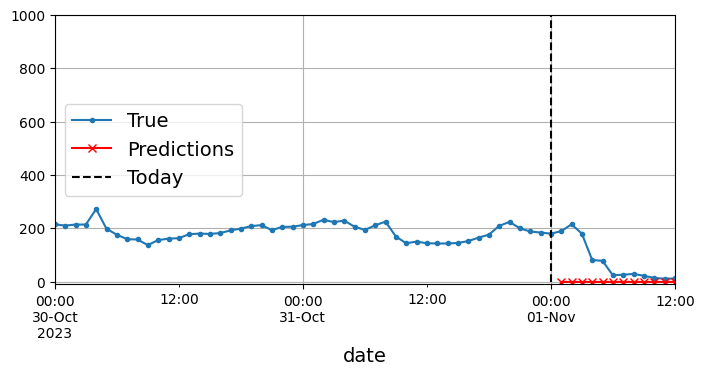

In [50]:
fig, ax = plt.subplots(figsize=(8, 3.5))
true_values = scaler_target.inverse_transform(val["contaminacion"].values.reshape(-1, 1))
true_values = np.expm1(true_values)
true_values = pd.Series(true_values.flatten(), index=val.index)["2023-10-30-00":final_val]
true_values.plot(label="True", marker=".", ax=ax)
Y_pred = scaler_target.inverse_transform(Y_pred.reshape(-1, 1))
Y_pred = np.expm1(Y_pred)
Y_pred = pd.Series(Y_pred.flatten(), index=pd.date_range("2023-11-01-01", periods=12, freq='H'))
Y_pred.plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2023-11-01-00", 0, 1000, color="k", linestyle="--", label="Today")
ax.set_ylim([-10, 1000])
plt.legend(loc="center left")
plt.show()

In [51]:
# Select the true values for the same time period as the predictions
true_values = val["contaminacion"]["2023-11-01-01":"2023-11-01-12"]

print("RMSE:", np.sqrt(mean_squared_error(true_values, Y_pred)))
print("MAPE:", mean_absolute_percentage_error(true_values, Y_pred)*100)

RMSE: 1.5465486
MAPE: 294.5391654968262


### Ejercicio 9

Crea un modelo con una capa de celdas LSTM con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.

In [52]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32,  input_shape=[None, 11]),
    tf.keras.layers.Dense(12)
])

In [53]:
#fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,
 #                learning_rate=0.1, epochs=5)
fit_and_evaluate(lstm_model, train_ds, valid_ds,
                 learning_rate=0.1, epochs = 500)

Epoch 1/500


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0750 - mae: 0.1228 - val_loss: 0.0015 - val_mae: 0.0310
Epoch 2/500
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0694 - mae: 0.0959 - val_loss: 0.0013 - val_mae: 0.0281
Epoch 3/500
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0675 - mae: 0.0934 - val_loss: 0.0013 - val_mae: 0.0270
Epoch 4/500
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0659 - mae: 0.0907 - val_loss: 0.0015 - val_mae: 0.0264
Epoch 5/500
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0650 - mae: 0.0898 - val_loss: 0.0016 - val_mae: 0.0265
Epoch 6/500
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0637 - mae: 0.0884 - val_loss: 0.0018 - val_mae: 0.0282
Epoch 7/500
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0635 - mae: 0.0892 - val_loss: 0.0012 - val_mae: 0.0274
Epoch 8/500
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.0634 - mae: 0.0898 - val_loss: 0.0011 - val_mae: 0.0270
Epoch 9/500
1027/1027 ━━━━━━━━━━━━━━━━━

0.02643863670527935

In [60]:
X = val.to_numpy()[np.newaxis, :seq_length]  
Y_pred = lstm_model.predict(X)  
Y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


array([[-0.07491484, -0.11238375, -0.12837334, -0.21388245, -0.16981302,
        -0.14536119, -0.15388526, -0.34529972, -0.10133088, -0.05875964,
        -0.0212166 , -0.07883802]], dtype=float32)

In [62]:
Y_pred = scaler_target.inverse_transform(np.expm1(Y_pred))  # Desnormalización
Y_pred

array([[-0.49822274, -0.733753  , -0.8316082 , -1.3291693 , -1.0780526 ,
        -0.93387264, -0.98453546, -2.015545  , -0.6651898 , -0.39391613,
        -0.14491005, -0.52329963]], dtype=float32)

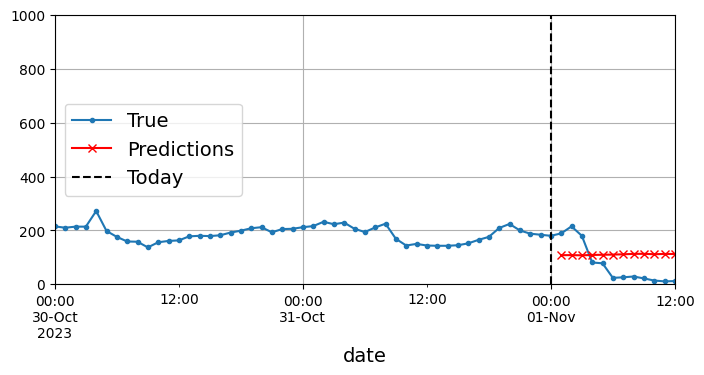

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3.5))
true_values = scaler_target.inverse_transform(val["contaminacion"].values.reshape(-1, 1))
true_values = np.expm1(true_values)
true_values = pd.Series(true_values.flatten(), index=val.index)["2023-10-30-00":final_val]
true_values.plot(label="True", marker=".", ax=ax)
Y_pred = scaler_target.inverse_transform(Y_pred.reshape(-1, 1))
Y_pred = np.expm1(Y_pred)
Y_pred = pd.Series(Y_pred.flatten(), index=pd.date_range("2023-11-01-01", periods=12, freq='H'))
Y_pred.plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2023-11-01-00", 0, 1000, color="k", linestyle="--", label="Today")
ax.set_ylim([-10, 1000])
plt.legend(loc="center left")
plt.show()

In [63]:
# Select the true values for the same time period as the predictions
true_values = val["contaminacion"]["2023-11-01-01":"2023-11-01-12"]

print("RMSE:", np.sqrt(mean_squared_error(true_values, Y_pred.flatten())))
print("MAPE:", mean_absolute_percentage_error(true_values, Y_pred.flatten())*100)

RMSE: 1.4859859
MAPE: 257.67972469329834


### Ejercicio 10

Crea un modelo con una capa de celdas GRU con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.

In [64]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, input_shape=[None, 11]),
    tf.keras.layers.Dense(12)
])

In [65]:
fit_and_evaluate(gru_model, train_ds, valid_ds, learning_rate=0.1, epochs=500)

Epoch 1/500


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0759 - mae: 0.1276 - val_loss: 0.0021 - val_mae: 0.0343
Epoch 2/500
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0670 - mae: 0.0937 - val_loss: 0.0025 - val_mae: 0.0342
Epoch 3/500
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0659 - mae: 0.0906 - val_loss: 0.0032 - val_mae: 0.0347
Epoch 4/500
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0650 - mae: 0.0898 - val_loss: 0.0040 - val_mae: 0.0376
Epoch 5/500
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0625 - mae: 0.0871 - val_loss: 0.0043 - val_mae: 0.0370
Epoch 6/500
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0634 - mae: 0.0880 - val_loss: 0.0052 - val_mae: 0.0424
Epoch 7/500
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.0630 - mae: 0.0883 - val_loss: 0.0059 - val_mae: 0.0357
Epoch 8/500
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0640 - mae: 0.0894 - val_loss: 0.0067 - val_mae: 0.0388
Epoch 9/500
1027/1027 ━━━━━━

0.034185413271188736

In [66]:
X = val.to_numpy()[np.newaxis, :seq_length, np.newaxis]

In [76]:
X

array([[[[  0.6273931 ,  -0.09790151,  -1.0586437 , -97.04224   ,
           -0.47490752,  -0.17112121,  -0.24223875,   8.333894  ,
           -2.1161861 ,  -2.3131034 ,  -1.7996219 ]],

        [[  0.634824  ,  -0.09790151,  -1.0586437 , -97.04224   ,
           -0.47453013,  -0.17112121,  -0.24223875,   8.333894  ,
           -2.1161861 ,  -2.3131034 ,  -1.7996219 ]],

        [[  0.664224  ,  -0.09790151,  -1.0586437 , -97.04224   ,
           -0.47528914,  -0.17112121,  -0.24223875,  -1.4904706 ,
           -2.1161861 ,  -2.3131034 ,   4.110381  ]],

        [[  0.67559224,  -0.10733378,  -1.0653563 , -97.05135   ,
           -0.47491178,  -0.17112121,  -0.24223875,  -1.4904706 ,
           -2.1161861 ,  -2.3131034 ,   4.110381  ]],

        [[  0.67559224,  -0.10261764,  -1.0653563 , -97.05135   ,
           -0.47453436,  -0.17112121,  -0.24223875,  -1.4904706 ,
           -2.1161861 ,  -2.3131034 ,   4.110381  ]],

        [[  0.67830014,  -0.10261764,  -1.0653563 , -97.04224   ,

In [ ]:
for step_ahead in range(12):
    y_pred_one = gru_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)
      

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

In [ ]:
Y_pred = pd.Series(X[0, -12:, 0],
                   index=pd.date_range("2023-11-01-01", "2023-11-01-12"))

fig, ax = plt.subplots(figsize=(8, 3.5))
true_values = scaler_target.inverse_transform(val["contaminacion"].values.reshape(-1, 1))
true_values = np.expm1(true_values)
true_values = pd.Series(true_values.flatten(), index=val.index)["2023-10-30-00":final_val]
true_values.plot(label="True", marker=".", ax=ax)
Y_pred = scaler_target.inverse_transform(Y_pred.reshape(-1, 1))
Y_pred = np.expm1(Y_pred)
Y_pred = pd.Series(Y_pred.flatten(), index=pd.date_range("2023-11-01-01", periods=12, freq='H'))
Y_pred.plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2023-11-01-00", 0, 1000, color="k", linestyle="--", label="Today")
ax.set_ylim([-10, 1000])
plt.legend(loc="center left")
plt.show()

In [ ]:
print("RMSE:", np.sqrt(mean_squared_error(true_values, Y_pred)))
print("MAPE:", mean_absolute_percentage_error(true_values, Y_pred) * 100)